In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from z3 import *

In [2]:
# More z3 practice. Very slow without help.
# Thankfully with a bit of manual help on the
# negatives solves in a not unreasonable amount 
# of time

# I suspect the negative number placements are all forced
# but haven't proved it. 

url='https://www.janestreet.com/puzzles/number-cross-3/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
print(" ".join(x[7:9]))

Enter the digits 1 thru 9, or their negatives, in each of the squares in the crossword grid.  The crossword clues represent the sum of the digits in each answer.   Ignoring sign, no digit will appear more than once in any row or column in the completed grid.  Also, every row and column of the completed grid has exactly one negative number. For your answer, submit the sum of all numbers in the grid which share a border (horizontal or vertical) with one of the negative numbers.


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/07/jul16_puzzle.png" width="350">

Solved Grid
~~~~~~~~~~~


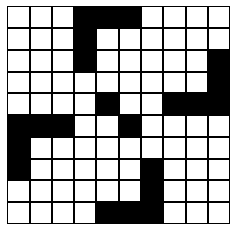

In [7]:
#### set up a nice output grid
fixed= np.zeros((10,10),dtype=int)
fixed[0,3:6] = 1
fixed[1,3] = 1
fixed[2,3] = 1
fixed[2:5,9] = 1
fixed[2,3] = 1
fixed[4,4] = 1
fixed[4,7:10] = 1
fixed[5,0:3] = 1
fixed[5,5] = 1
fixed[6:8,0] = 1
fixed[7:9,6] = 1
fixed[9,4:7] = 1

def print_grid(fixed,solved):
    annot = solved.copy()
    grid=fixed.copy()
    annot[grid==1] = 0
    print("Solved Grid")
    print("~~~~~~~~~~~")
    annot = annot.astype('str')
    annot[annot=="0"] =""
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    ax =sns.heatmap(grid,annot=annot,cbar=False,cmap="Greys",fmt="",linewidths=1,annot_kws={"size":14},linecolor='k')
    ax.axis("off")
    plt.show()
    
print_grid(fixed,fixed)    

In [12]:
######################################################
# Setup # 9x9 matrix of integer variables and solver #
######################################################

# 2 lists of variables one for the digit one for negatives
X = [[Int("x_%s_%s" % (i+1, j+1)) for j in range(10) ] for i in range(10)]
Y = [[Int("y_%s_%s" % (i+1, j+1)) for j in range(10) ] for i in range(10)]

s = Solver()

###############################
# The puzzle wide constraints #
###############################

# only one negative number in each row/column
s+=  [PbEq([(Y[i][j] ==-1,1) for j in range(10) if fixed[i,j]==0],1) for i in range(10)]
s+=  [PbEq([(Y[i][j] ==-1,1) for i in range(10) if fixed[i,j]==0],1) for j in range(10)]

# each digit only once in each row/column
s += [Distinct([X[i][j] for j in range(10) if fixed[i,j]==0]) for i in range(10)]
s += [Distinct([X[i][j] for i in range(10) if fixed[i,j]==0]) for j in range(10)]

# each cell contains a value in {1 ..., 9}
s += [And(1 <= X[i][j], X[i][j] <= 9) for i in range(10) for j in range(10)]
s += [Or(Y[i][j]==1, Y[i][j]==-1) for i in range(10) for j in range(10)]

#fix the shaded cells at 1
for i,j in itertools.product(range(10),range(10)):    
    if fixed[i,j] ==1:
        s+= X[i][j] == 1
        s+= Y[i][j] == 1


################################################################
# Based on totals some numbers have to have a negative in them #
################################################################

# Just solving the clues is very slow
# Thankfully the negatives can't be in a number of places
# The negative, zero & 1 answers must have a negative meaning 
# the other cells in that row/col can't have negatives
# Where the cell is below the lowest sum possible (4 digits cant be lower than 1+2+3+4 say)
# that must have a negative so the rest can't
# 3 digits 17 or greater can't have negative

forced= np.array([[1,1,1,1,1,1,0,0,1,0],
                  [1,1,1,1,1,0,0,0,1,0],
                  [1,0,1,1,1,1,1,1,1,1],
                  [1,1,1,0,1,0,0,0,1,1],
                  [1,1,1,0,1,0,0,1,1,1],
                  [1,1,1,0,0,1,1,1,1,1],
                  [1,1,1,1,1,1,1,1,0,1],
                  [1,1,0,0,0,0,0,1,1,1],
                  [0,1,0,0,0,0,1,1,1,1],
                  [0,1,0,0,1,1,1,1,1,1]]
          ,dtype=int)

for i,j in itertools.product(range(10),range(10)):    
    if forced[i,j] ==1:
  
        s+= Y[i][j] == 1

#############
# The clues #
#############       

### ACROSS ###
# 1 across
s += X[0][0]*Y[0][0]+X[0][1]*Y[0][1]+X[0][2]*Y[0][2] ==24   

# 4 across
s += X[0][6]*Y[0][6]+X[0][7]*Y[0][7]+X[0][8]*Y[0][8]+X[0][9]*Y[0][9] == 14     

# 8 across
s += X[1][0]*Y[1][0]+X[1][1]*Y[1][1]+X[1][2]*Y[1][2] ==10  

# 9 across
s += X[1][4]*Y[1][4]+X[1][5]*Y[1][5]+X[1][6]*Y[1][6]+X[1][7]*Y[1][7]+X[1][8]*Y[1][8]+X[1][9]*Y[1][9] == 25     

# 11 across
s += X[2][0]*Y[2][0]+X[2][1]*Y[2][1]+X[2][2]*Y[2][2] == 0  

# 12 across
s += X[2][4]*Y[2][4]+X[2][5]*Y[2][5]+X[2][6]*Y[2][6]+X[2][7]*Y[2][7]+X[2][8]*Y[2][8] == 19     

# 13 across
s += X[3][0]*Y[3][0]+X[3][1]*Y[3][1]+X[3][2]*Y[3][2]+X[3][3]*Y[3][3]+X[3][4]*Y[3][4]+X[3][5]*Y[3][5] +X[3][6]*Y[3][6] +X[3][7]*Y[3][7] +X[3][8]*Y[3][8]  == 41     

# 15 across
s += X[4][0]*Y[4][0]+X[4][1]*Y[4][1]+X[4][2]*Y[4][2]+X[4][3]*Y[4][3] == 23  

# 16 across
s += X[4][5]*Y[4][5]+X[4][6]*Y[4][6] ==6

# 17 across
s += X[5][3]*Y[5][3]+X[5][4]*Y[5][4] ==-8

# 19 across
s += X[5][6]*Y[5][6]+X[5][7]*Y[5][7]+X[5][8]*Y[5][8]+X[5][9]*Y[5][9] == 14  

# 23 across
s += X[6][1]*Y[6][1]+X[6][2]*Y[6][2]+X[6][3]*Y[6][3]+X[6][4]*Y[6][4]+X[6][5]*Y[6][5] +X[6][6]*Y[6][6] +X[6][7]*Y[6][7] +X[6][8]*Y[6][8]+X[6][9]*Y[6][9]  == 39    

# 26 across
s += X[7][1]*Y[7][1]+X[7][2]*Y[7][2]+X[7][3]*Y[7][3]+X[7][4]*Y[7][4]+X[7][5]*Y[7][5] == 15    

# 27 across
s += X[7][7]*Y[7][7]+X[7][8]*Y[7][8]+X[7][9]*Y[7][9] == 17    

# 28 across
s += X[8][0]*Y[8][0]+X[8][1]*Y[8][1]+X[8][2]*Y[8][2]+X[8][3]*Y[8][3]+X[8][4]*Y[8][4]+X[8][5]*Y[8][5] == 17   

# 29 across
s += X[8][7]*Y[8][7]+X[8][8]*Y[8][8]+X[8][9]*Y[8][9] == 22 

# 30 across
s += X[9][0]*Y[9][0]+X[9][1]*Y[9][1]+X[9][2]*Y[9][2]+X[9][3]*Y[9][3] == 8  

# 31 across
s += X[9][7]*Y[9][7]+X[9][8]*Y[9][8]+X[9][9]*Y[9][9] == 10 

### DOWN ###
# 1 down
s += X[0][0]*Y[0][0]+X[1][0]*Y[1][0]+X[2][0]*Y[2][0]+X[3][0]*Y[3][0]+X[4][0]*Y[4][0] == 17     

# 2 down
s += X[0][1]*Y[0][1]+X[1][1]*Y[1][1]+X[2][1]*Y[2][1]+X[3][1]*Y[3][1]+X[4][1]*Y[4][1] == 6     
                                                                                  
# 3 down
s += X[0][2]*Y[0][2]+X[1][2]*Y[1][2]+X[2][2]*Y[2][2]+X[3][2]*Y[3][2]+X[4][2]*Y[4][2] == 35     

# 4 down
s += X[0][6]*Y[0][6]+X[1][6]*Y[1][6]+X[2][6]*Y[2][6]+X[3][6]*Y[3][6]+X[4][6]*Y[4][6]+X[5][6]*Y[5][6]+X[6][6]*Y[6][6]  == 32 

# 5 down
s += X[0][7]*Y[0][7]+X[1][7]*Y[1][7]+X[2][7]*Y[2][7]+X[3][7]*Y[3][7] == 13 

# 6 down
s += X[0][8]*Y[0][8]+X[1][8]*Y[1][8]+X[2][8]*Y[2][8]+X[3][8]*Y[3][8] == 30  

# 7 down
s += X[0][9]*Y[0][9]+X[1][9]*Y[1][9]== 8 

# 9 down
s += X[1][4]*Y[1][4]+X[2][4]*Y[2][4]+X[3][4]*Y[3][4]== 8

# 10 down
s += X[1][5]*Y[1][5]+X[2][5]*Y[2][5]+X[3][5]*Y[3][5]+X[4][5]*Y[4][5]== 19

# 14 down
s += X[3][3]*Y[3][3]+X[4][3]*Y[4][3]+X[5][3]*Y[5][3]+X[6][3]*Y[6][3]+X[7][3]*Y[7][3]+X[8][3]*Y[8][3]+X[9][3]*Y[9][3] == 30

# 18 down
s += X[5][4]*Y[5][4]+X[6][4]*Y[6][4]+X[7][4]*Y[7][4]+X[8][4]*Y[8][4] == 4

# 20 down
s += X[5][7]*Y[5][7]+X[6][7]*Y[6][7]+X[7][7]*Y[7][7]+X[8][7]*Y[8][7]+X[9][7]*Y[9][7] == 22

# 21 down
s += X[5][8]*Y[5][8]+X[6][8]*Y[6][8]+X[7][8]*Y[7][8]+X[8][8]*Y[8][8]+X[9][8]*Y[9][8] == 9

# 22 down
s += X[5][9]*Y[5][9]+X[6][9]*Y[6][9]+X[7][9]*Y[7][9]+X[8][9]*Y[8][9]+X[9][9]*Y[9][9] == 30

# 23 down
s += X[6][1]*Y[6][1]+X[7][1]*Y[7][1]+X[8][1]*Y[8][1]+X[9][1]*Y[9][1] == 21

# 24 down
s += X[6][2]*Y[6][2]+X[7][2]*Y[7][2]+X[8][2]*Y[8][2]+X[9][2]*Y[9][2] == 4

# 25 down
s += X[6][5]*Y[6][5]+X[7][5]*Y[7][5]+X[8][5]*Y[8][5] == 7

# 28 down
s += X[8][0]*Y[8][0]+X[9][0]*Y[9][0] == 1


def find_negs(fixed,grid):
    output = grid.copy()
    output[fixed ==1] =0
    
    negs = np.zeros((10,10),dtype = int)
    for row,col in itertools.product(range(10),range(10)):
        
        if row-1 > -1:
             if output[row-1,col] <0:
                negs[row,col] = 1
                   
        if row+1 <10:
             if output[row+1,col] <0:

                negs[row,col] = 1
        if col-1 > -1:
             if output[row,col-1] <0:
                negs[row,col] = 1
         
                                  
        if col+1 <10:
             if output[row,col+1] <0:
                negs[row,col] = 1

    return np.sum(negs*output)
                        

Solved in 286.2488 seconds

The sum is: 148

Solved Grid
~~~~~~~~~~~


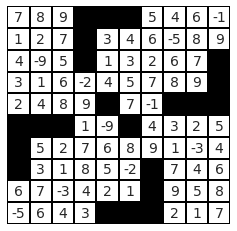

In [13]:
start =time.time()                                                                                
                                                                             
###################
# Solve and print #
###################
if s.check() == sat:
    m = s.model()
    x_result = [[ m.evaluate(X[i][j]).as_long() for j in range(10) ] for i in range(10)]
    y_result = [[ m.evaluate(Y[i][j]).as_long() for j in range(10) ] for i in range(10)]
else:
    print("Failed")


stop = time.time()
print("Solved in {:.4f} seconds\n".format(stop-start))
print("The sum is: {}\n".format(find_negs(fixed,np.array(x_result)*np.array(y_result))))
print_grid(fixed,np.array(x_result)*np.array(y_result))

In [6]:
url='https://www.janestreet.com/puzzles/solutions/july-2016-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The completed grid is presented here, and the sum of all numbers bordering the negative numbers is 148 .  Congratulations to all of this month’s correct solvers!


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/08/jul16_solution.png" width="300" >

<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/07/jul16_puzzle.png" width="400">

Solved in 0.0738 seconds

Solved Grid
~~~~~~~~~~~


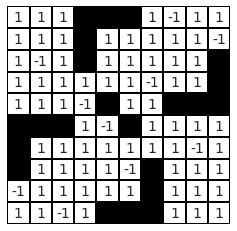

In [10]:
start =time.time()
forced= np.array([[1,1,1,1,1,1,0,0,1,0],
                  [1,1,1,1,1,0,0,0,1,0],
                  [1,0,1,1,1,1,1,1,1,1],
                  [1,1,1,0,1,0,0,0,1,1],
                  [1,1,1,0,1,0,0,1,1,1],
                  [1,1,1,0,0,1,1,1,1,1],
                  [1,1,1,1,1,1,1,1,0,1],
                  [1,1,0,0,0,0,0,1,1,1],
                  [0,1,0,0,0,0,1,1,1,1],
                  [0,1,0,0,1,1,1,1,1,1]]
          ,dtype=int)

s = Solver()

Y = [[Int("y_%s_%s" % (i+1, j+1)) for j in range(10) ] for i in range(10)]
s += [Or(Y[i][j]==1, Y[i][j]==-1) for i in range(10) for j in range(10)]

s+=  [PbEq([(Y[i][j] ==-1,1) for j in range(10) if fixed[i,j]==0],1) for i in range(10)]
s+=  [PbEq([(Y[i][j] ==-1,1) for i in range(10) if fixed[i,j]==0],1) for j in range(10)]



for i,j in itertools.product(range(10),range(10)):    
    if forced[i,j] ==1:  
        s+= Y[i][j] == 1

   
if s.check() == sat:
    m = s.model()
    
    y_result = [[ m.evaluate(Y[i][j]).as_long() for j in range(10) ] for i in range(10)]
else:
    print("Failed")


stop = time.time()
print("Solved in {:.4f} seconds\n".format(stop-start))

print_grid(fixed,np.array(y_result))

In [11]:
9+8+7+6

30